
This notebook is a solution for the multi-horizon forecasting in the context of a big chain of stores retail business. The task is to forecast the numbers of daily customers up to 50 days ahead. 
The notebook is structured as follows: 
 - Small Exploratory Data Analysis 
 - Implementation of Naive model used in benchmarking: Weighted average of previous observation of the same day of the week 
 - Implementation of a Recursive Global Gradient Boosting model
 - Implementation of a Hybrid model where a train multiple Direct Global Gradient Boosting models for p-steps prediction. 


**Note:** All the function I use in this notebook are written in **utils.py** and **global_model_util.py** scripts


In [ ]:
#If necessaty install the following required packages
#!pip install optuna, joblib

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random

#import scripts written for this project
import utils
import global_model_util


df = pd.read_parquet('n_forecast.parquet', engine='pyarrow', dtype_backend='numpy_nullable')
df.drop_duplicates(inplace=True)
df['sales_date'] = pd.to_datetime(df['sales_date'])
df.head()

,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,...,holiday_eid_al_fitr,holiday_valentines_day,autumn_school_holiday,summer_school_holiday,spring_school_holiday,christmas_school_holiday,may_school_holiday,easter_school_holiday,datetime_store_open,datetime_store_closed
0,2019-01-02,b9d487a30398d42ecff55c228ed5652b,6570,19,68,south,0,0,0,0,...,0,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00
1,2019-01-02,c3e0c62ee91db8dc7382bde7419bb573,1773,6,30,middle,0,0,0,0,...,0,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00
2,2019-01-02,90db9da4fc5414ab55a9fe495d555c06,8783,19,10,north,0,0,0,0,...,0,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00
3,2019-01-02,07042ac7d03d3b9911a00da43ce0079a,5391,19,10,north,0,0,0,0,...,0,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 22:00:00
4,2019-01-02,b60c5ab647a27045b462934977ccad9a,2789,6,96,north,0,0,0,0,...,0,0,0,0,0,1,0,0,2019-01-02 08:00:00,2019-01-02 20:00:00


## Exploratory data analysis

I perform a small EDA that can help me better understand the nature of the data and potential anomalies that could impact the performance of the models. 

In [2]:
df.isnull().sum()

sales_date                                 0
store_hashed                               0
n_transactions                             0
store_format                               0
zipcode_region                             0
region                                     0
holiday_saint_nicholas                     0
holiday_first_christmas                    0
holiday_liberation_day                     0
holiday_good_friday                        0
holiday_new_years_day                      0
holiday_mothers_day                        0
holiday_fathers_day                        0
holiday_carnaval                           0
holiday_easter                             0
holiday_pentecost                          0
holiday_kings_day_netherlands              0
holiday_kings_day_belgium                  0
holiday_all_saints_day                     0
holiday_all_souls_day                      0
holiday_penance_and_prayer_day             0
holiday_german_unity_day                   0
holiday_la

There are relatively few missing values for datetime_store_open and datetime_store_closed (less then 0.1% observations), but I choose to keep them in the dataset given the time series nature of the data. I will further investigate the nature of these observations and/or use imputation techniques to deal with any relevant derived features. 

In [3]:
print(f'Number of observations with with smaller than (or equal to) 0 n_transactions:  {df[df.n_transactions <= 0].n_transactions.count()} observations')

Number of observations with with smaller than (or equal to) 0 n_transactions:  0 observations


In [4]:
print("Number of unique stores in the dataset: ", df['store_hashed'].nunique())
#last operating day for each store
last_operating_day = df.groupby('store_hashed')['sales_date'].max().reset_index()
last_operating_day.sales_date.value_counts().sort_index(ascending=False)

Number of unique stores in the dataset:  595


sales_date
2022-12-31    575
2022-12-30      5
2022-12-23      3
2022-12-22      2
2022-11-06      1
2022-07-23      1
2021-12-17      1
2021-03-28      1
2021-03-27      1
2020-03-16      1
2020-02-21      1
2020-01-30      1
2020-01-11      2
Name: count, dtype: int64

There are 20 stores which were not operational on 31 December 2022. I assume stores with transactions in December 2023 are still operational stores. 

Number of unique stores in the dataset:  10


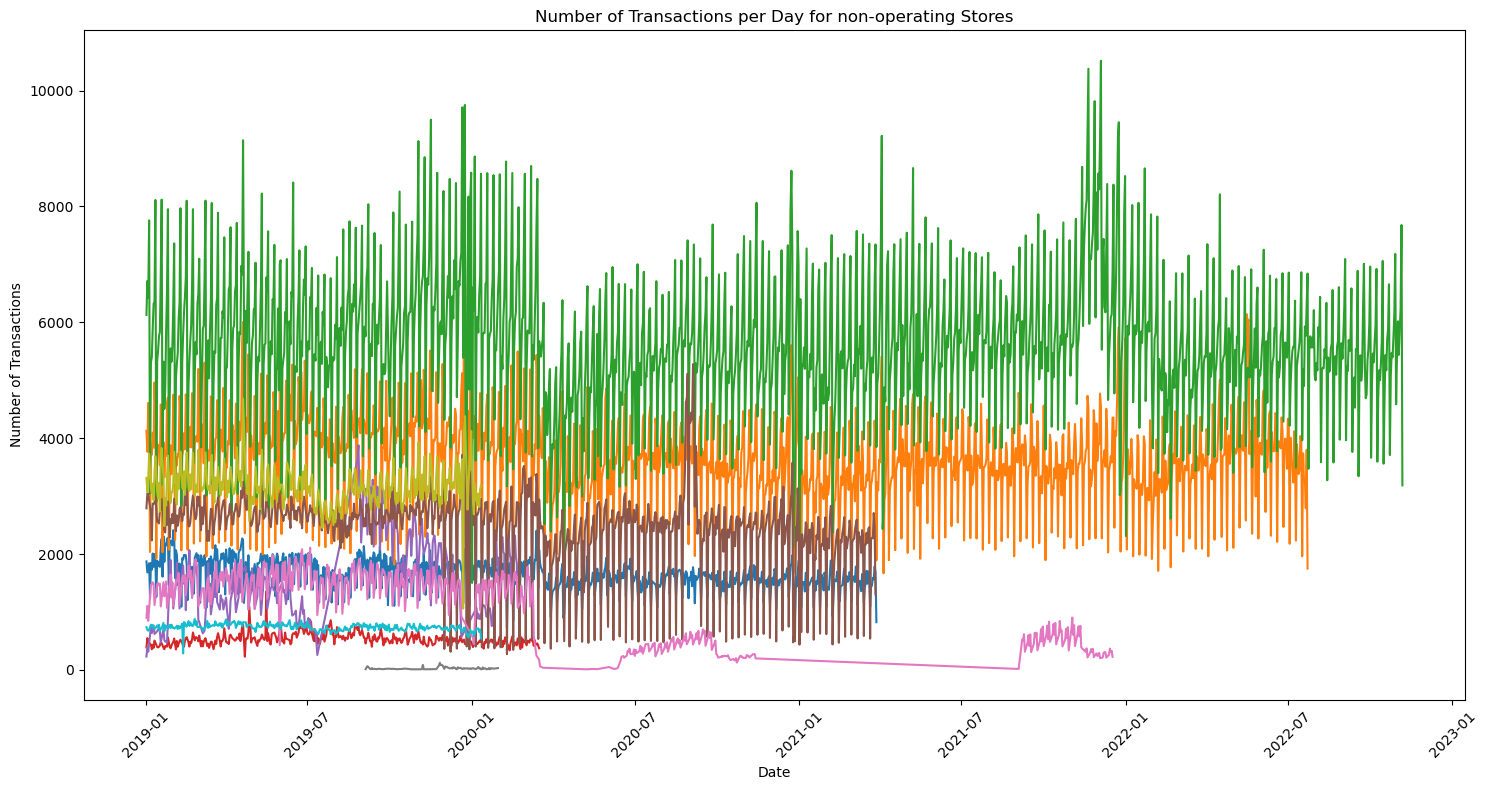

In [5]:
non_operating_stores_ids = last_operating_day[last_operating_day['sales_date'] < pd.to_datetime('2022-12-22')]['store_hashed'].unique()
non_operating_stores =df[df['store_hashed'].isin(non_operating_stores_ids)]
non_operating_stores = non_operating_stores.sort_values(by=['store_hashed', 'sales_date'])

print("Number of unique stores in the dataset: ", non_operating_stores['store_hashed'].nunique())

plt.figure(figsize=(15, 8))
for store in non_operating_stores['store_hashed'].unique():
    store_data = non_operating_stores[non_operating_stores['store_hashed'] == store]
    plt.plot(store_data['sales_date'], store_data['n_transactions'], label=f'Store {store}')
plt.title('Number of Transactions per Day for non-operating Stores')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


I choose to exclude the non-operational stores from the dataset. I assume they are no longer relevant for future operations. In additiona to that, they might exibit specifit patterns that could potentially induce biases into specific global forecasting models. Fore example, before closing there might be stores that offer substantial discounts that can positively influence the number of transactions during that period. Lastly, excluding these 10 stores from the dataset will not have a significant impact in developing a forecasting model 

Number of stores with operational breaks (7 days):  109 , with multiple breaks:  12
Number of stores with operational breaks (14 days):  34 , with multiple breaks:  5
Number of stores with operational breaks (30 days):  10 , with multiple breaks:  4


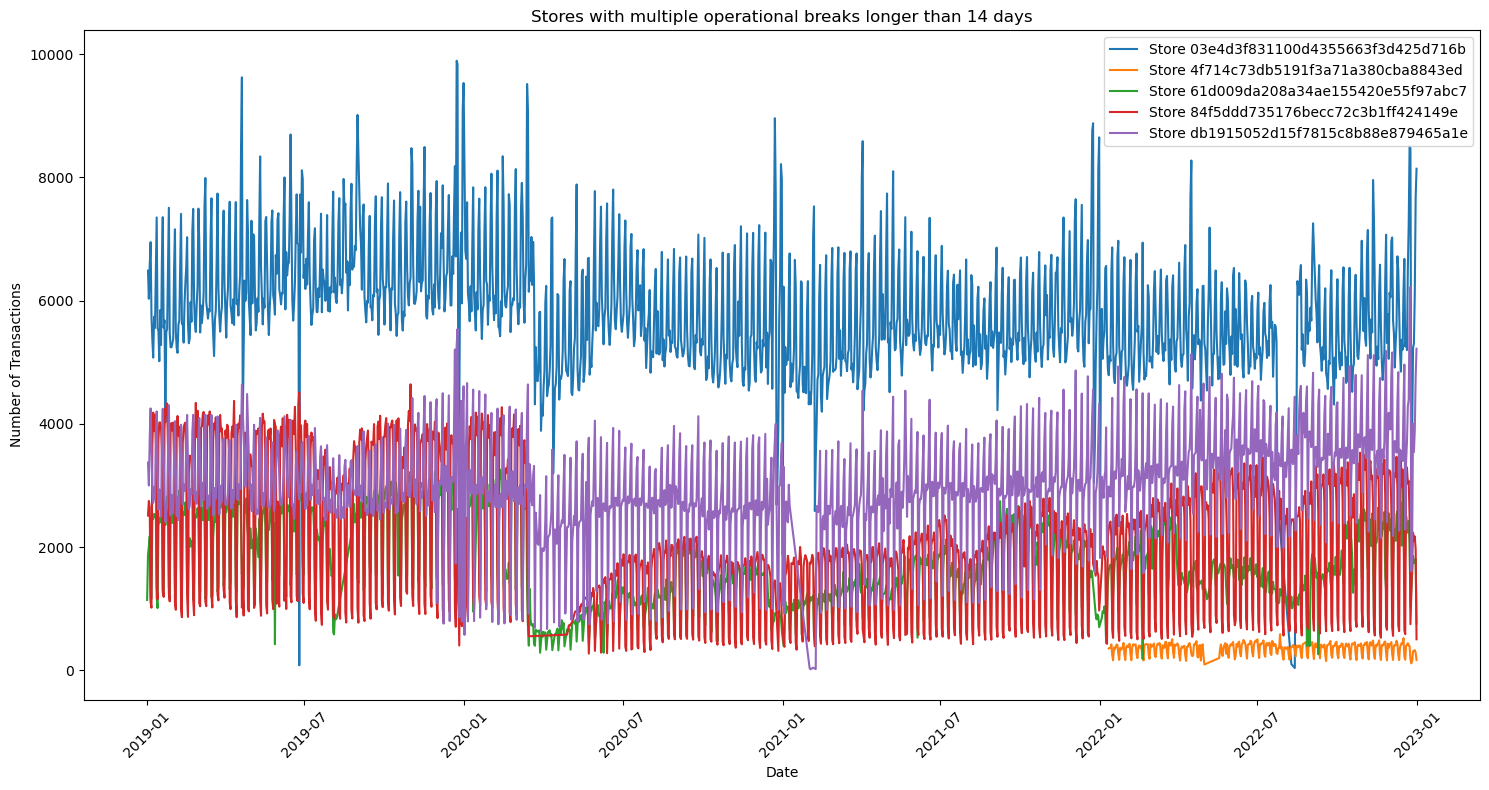

In [6]:
#Exclude non-operating stores from the dataset
df = df[~df['store_hashed'].isin(non_operating_stores_ids)]

# Find the stores with operational breaks in the dataset
stores_with_breaks_14, multiple_breaks_14 = utils.stores_with_operational_breaks(df, break_days=14)
stores_with_breaks_7, multiple_breaks_7= utils.stores_with_operational_breaks(df, break_days=7)
stores_with_breaks_30, multiple_breaks_30 = utils.stores_with_operational_breaks(df, break_days=30)
print("Number of stores with operational breaks (7 days): ", len(stores_with_breaks_7), ", with multiple breaks: ", len(multiple_breaks_7))
print("Number of stores with operational breaks (14 days): ", len(stores_with_breaks_14), ", with multiple breaks: ", len(multiple_breaks_14))
print("Number of stores with operational breaks (30 days): ", len(stores_with_breaks_30), ", with multiple breaks: ", len(multiple_breaks_30))

# Plot the stores with operational breaks longer than 14 days
sample_stores = random.sample(list(stores_with_breaks_14),5)
#print("Sample stores with operational breaks: ", sample_stores)
stores_with_breaks_df = df[df['store_hashed'].isin(sample_stores)]
stores_with_breaks_df = stores_with_breaks_df.sort_values(by=['store_hashed', 'sales_date'])
plt.figure(figsize=(15, 8))
for store in stores_with_breaks_df['store_hashed'].unique():
    store_data = stores_with_breaks_df[stores_with_breaks_df['store_hashed'] == store]
    plt.plot(store_data['sales_date'], store_data['n_transactions'], label=f'Store {store}')
plt.title('Stores with multiple operational breaks longer than 14 days')
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

There are 5 stores with multiple operational breaks longer than 14 days, out of which 4 have longer than 30 days operational breaks.I consider these store to have a potential negative strong impact on the quality of an prediction models, such that I decide to eliminate these observations from the dataset. 

Upon closer inspection, anomalous low observations for some of the store correspond to missing values in the opening and closing times. Furthermore, I see that the majority of stores also have at least one break in the data longer than 1 day. This aspect is explainable, but it is important to account for in the context of feature engineering. At this point, I choose to completly remove the rows with missing values

In [7]:
stores_with_breaks_1, multiple_breaks_1 = utils.stores_with_operational_breaks(df, break_days=1)
print("Number of stores with operational breaks (1 day): ", len(stores_with_breaks_1), ", with multiple breaks: ", len(multiple_breaks_1))

Number of stores with operational breaks (1 day):  506 , with multiple breaks:  434


In [8]:
df_preprocessed = utils.preprocess_data(df)

print('Shape of the preprocessed data: ', df_preprocessed.shape)

df_preprocessed.head()

Shape of the preprocessed data:  (727875, 55)


,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,...,openning_hour,closing_hour,day_of_week,day_of_month,day_of_year,week_of_year,month,is_weekend,is_national_holiday,Covid19
482865,2021-12-15,01eee509ee2f68dc6014898c309e86bf,4269,19,30,middle,0,0,0,0,...,11,20,2,15,349,50,12,0,0,0
114297,2021-12-16,01eee509ee2f68dc6014898c309e86bf,3865,19,30,middle,0,0,0,0,...,7,20,3,16,350,50,12,0,0,0
512490,2021-12-17,01eee509ee2f68dc6014898c309e86bf,3396,19,30,middle,0,0,0,0,...,7,20,4,17,351,50,12,0,0,0
114324,2021-12-18,01eee509ee2f68dc6014898c309e86bf,3644,19,30,middle,0,0,0,0,...,8,20,5,18,352,50,12,0,0,0
129107,2021-12-19,01eee509ee2f68dc6014898c309e86bf,3167,19,30,middle,0,0,0,0,...,8,20,6,19,353,50,12,1,0,0


Throughout the experiments I consider a **80 days test set**. I plan to test the 50 days multiple-horizon models in multiple points in time across a month. 

In [9]:
train_set, test_set = utils.split_train_test(df_preprocessed, number_of_days=80)

## Naive model
My first approach is to build a one step naive model that will simply average across a predefined number of previous observations made in a same day of the week. The main purpose of this first approach is to establish a benchmark model that will help in judging the value of other considered models. I will consider a decaying weighted average since I consider that more recent weeks have a greater importance in predicting the future. Moreover I account for potential important national holidays that have a big impact upon purchasing behavior of the consumers. To put this mathematically: 

Let the terms used in the weighted average forecast be defined as follows:

$L_y$ : The number of transactions from the same day of the year, one year prior to the target day.

$M$ : The total number of recent weeks of historical data considered for the forecast .

$s_k$ : The number of transactions observed on the same day of the week as the target day, from past weeks. 

$w'_k$ : The normalized weight applied to the historical sale $s_k$. The weights are designed to give more importance to more recent weeks (i.e., $s_{M-1}$ gets the highest weight component). The weight for $s_k$ (where k is the 0-based index from 0 for oldest to M−1 for newest) is calculated as:
$$w'_k = \frac{k+1}{\sum_{j=1}^{M} j} = \frac{2(k+1)}{M(M+1)}$$

$\bar{S}_w$ : The weighted average of these M recent weekly sales:
$$\bar{S}_w = \sum_{k=0}^{M-1} w'_k s_k = \sum_{k=0}^{M-1} \left( \frac{2(k+1)}{M(M+1)} \cdot s_k \right)$$


The final forecast $\hat{Y}$ is then calculated based on the availability of valid sales data from last year:
$$
\hat{Y} =
\begin{cases}
0.25 \cdot L_y + 0.75 \cdot \bar{S}_w & \text{if } L_y > 0 \\
\bar{S}_w & \text{if } L_y \le 0 \text{ (or not considered valid)}
\end{cases}
$$

### Error measures 

I consider multiple error measure that could help me paint a broader picture in regards to the performance capability of the models

**RMSE (Root Mean Squared Error)** - I expect it will help me highlight the instances where larger error occur forecasting

**MAE (Mean Absolute Error)** -  I consider it for ease of interpretability

**MAPE (Mean Absolute Percentage Error)** - I consider it because of the scale independent nature and the ease of interpretability. Also it is especially helpful since there are no 0 value observations in the data

**sMAPE (symetric Mean Absolute Percentage Error)** - It can complement the MAPE since it doesn't disproportionately inflate the errors when the actual value is smaller. 

In [12]:
#for the naive model I only consider the a small subset of features
train_naive = train_set[['store_hashed', 'sales_date', 'day_of_week', 'n_transactions', 'is_national_holiday']].copy()
test_naive = test_set[['store_hashed', 'sales_date', 'n_transactions','day_of_week', 'is_national_holiday']].copy()

error_measures = ['RMSE', 'MAE', 'sMAPE', 'MAPE']

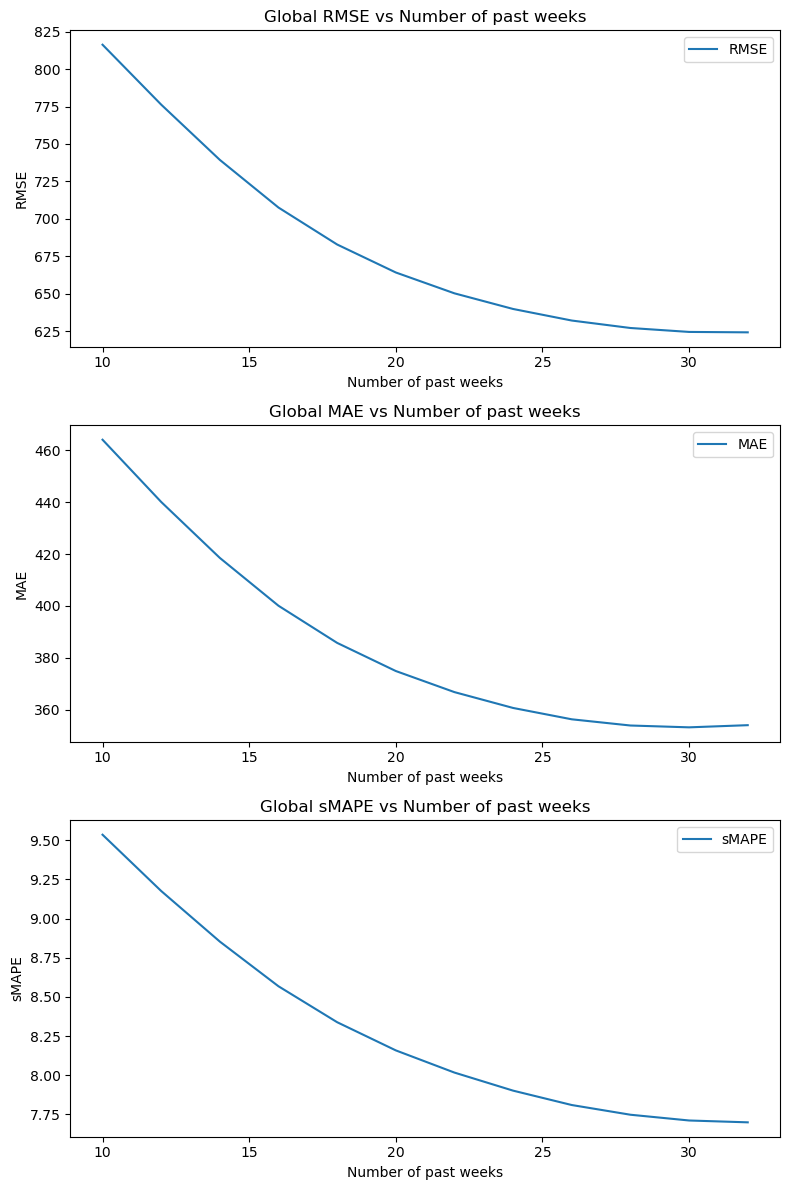

In [ ]:
# I consider a validation set of 50 days to help me choose the best number of past weeks in the naive model
# Running time warning: approximately 12 minutes running time (No need to run it again)
# If you want to run it again,uncomment the block of code bellow and consider running a smaller number of past weeks
# The optimal number of past weeks: 30  

#Get validation set used in finding the optimal number of past weeks

'''
tr_naive, ts_naive = utils.split_train_test(train_set, number_of_days = 50)

train_naive_val = tr_naive[['store_hashed', 'sales_date', 'day_of_week', 'n_transactions', 'is_national_holiday']].copy()
test_naive_val = ts_naive[['store_hashed', 'sales_date', 'n_transactions','day_of_week', 'is_national_holiday']].copy()

number_of_past_weeks = np.arange(10, 34, 2)
general_rmse_values = np.zeros(len(number_of_past_weeks))
general_mae_values = np.zeros(len(number_of_past_weeks))
general_smape_values = np.zeros(len(number_of_past_weeks))


for i, m_weeks in enumerate(number_of_past_weeks):
    test_df = utils.naive_weighted_forecast(train_naive_val, test_naive_val, m_weeks = m_weeks)
    rmse, mae, smape, _ = utils.metrics_accross_horizon(test_df, naive = True)
    general_rmse_values[i] = rmse.mean()
    general_mae_values[i] = mae.mean()
    general_smape_values[i] = smape.mean()



fig, ax = plt.subplots(3, 1, figsize=(8, 12))  
for i, error_measure, error_values in zip(range(len(error_measures)), error_measures, [general_rmse_values, general_mae_values, general_smape_values]):
    ax[i].plot(number_of_past_weeks, error_values, label=error_measure)
    ax[i].set_title(f'Global {error_measure} vs Number of past weeks')
    ax[i].set_ylabel(error_measure)
    ax[i].set_xlabel('Number of past weeks')
    ax[i].legend()
plt.tight_layout()
plt.show()
'''

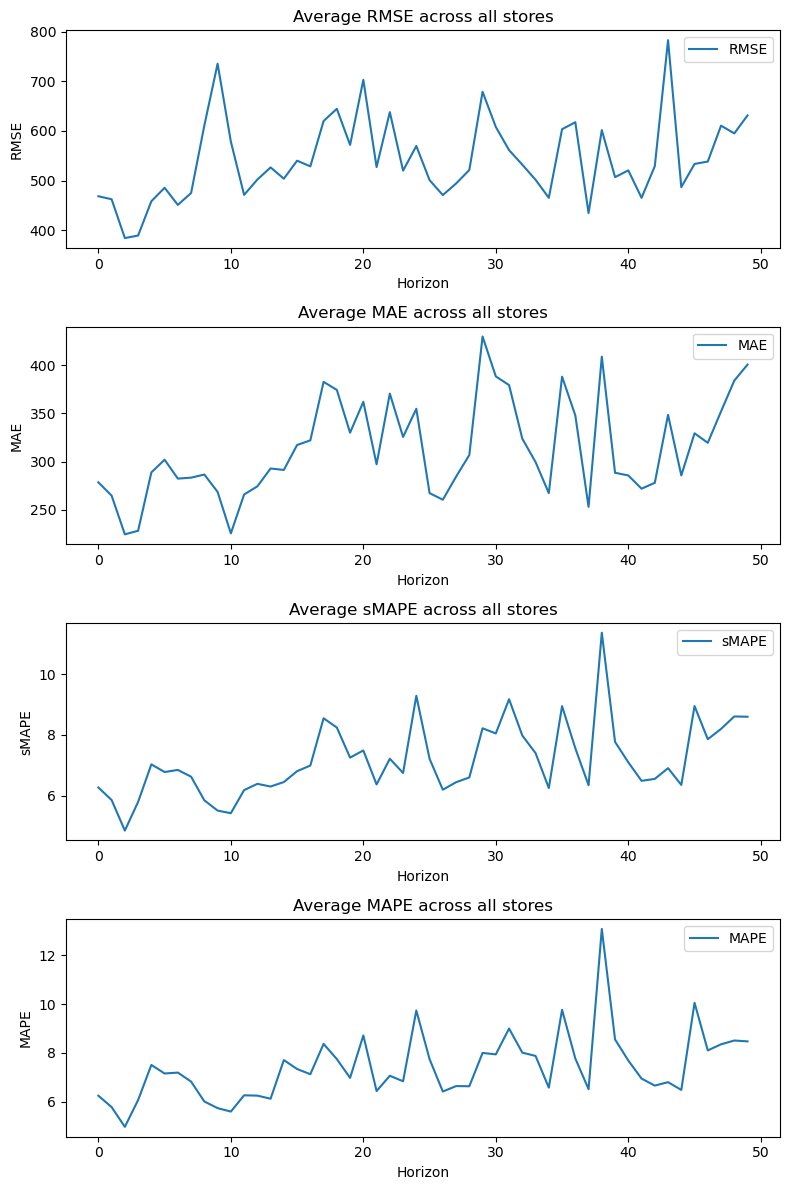

In [14]:
# Get the naive predictions using the optimal number of past weeks
test_df_naive = utils.naive_weighted_forecast(train_naive, test_naive, m_weeks = 30)
rmse_naive, mae_naive, mape_values, smape_naive = utils.metrics_accross_horizon(test_df_naive, naive = True)


fig, ax = plt.subplots(4, 1, figsize=(8, 12))
for i, error_measure, error_values in zip(range(len(error_measures)),error_measures, [rmse_naive, mae_naive, smape_naive, mape_values]):
    ax[i].plot(error_values, label=error_measure)
    ax[i].set_title(f'Average {error_measure} across all stores')
    ax[i].set_xlabel('Horizon')
    ax[i].set_ylabel(error_measure)
    ax[i].legend()
plt.tight_layout()
plt.show()


I find this to be a promsing start. The performance of the naive model is quite stable across the 50 days horizon (it's even better towards the end of the time interval). Also, the MAPE value betwee 6% - 12% is a good indication that a simple model like this already performs reasonably. 

After visualising the predictive performance of the naive model at one date, I choose to measure its performance in 6 different days accross one month. At each considered day the model predicts the number of transactions in the next 50 days for each store.

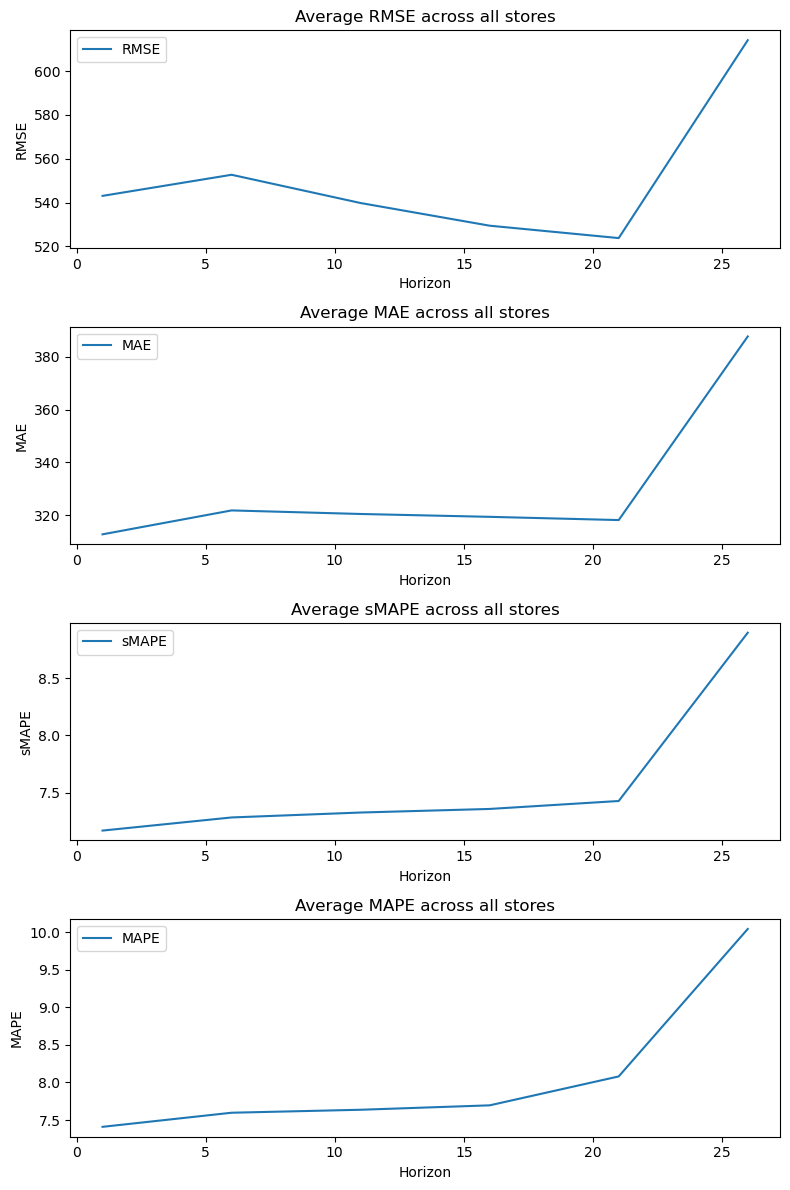

In [15]:
import os 

# RUNNING TIME WARNING: approximately 12 minutes running time. I save the results in csv format
#GRMSE_naive, GMAE_naive, GSMAPE_naive, GMAPE_naive = utils.rolling_window_forecast(test_naive, train_naive, m_weeks = 30, pred_horizon = 50, window_size = 5)

#SAVE THE RESULTS
#rolling_window_naive_results = pd.DataFrame({
#    'GRMSE': GRMSE_naive,
#    'GMAE': GMAE_naive,
#    'GSMAPE': GSMAPE_naive,
#    'GMAPE': GMAPE_naive
#})

models_save_directory = "models performance"
#os.makedirs(models_save_directory, exist_ok=True)
#rolling_window_naive_results.to_csv(f'{models_save_directory}/rolling_window_naive_results.csv', index = False)

#load the results
rolling_window_naive_results = pd.read_csv(f'{models_save_directory}/rolling_window_naive_results.csv')
days_of_forecast = np.arange(1, 31, 5)
fig, ax = plt.subplots(4, 1, figsize=(8, 12))
for i, error_measure, error_value in zip(range(len(error_measures)),error_measures, rolling_window_naive_results.columns):
    ax[i].plot(days_of_forecast, rolling_window_naive_results[error_value], label=error_measure)
    ax[i].set_title(f'Average {error_measure} across all stores')
    ax[i].set_xlabel('Horizon')
    ax[i].set_ylabel(error_measure)
    ax[i].legend()
plt.tight_layout()
plt.show()




## Global ML model - recursive approach 

**My first ML approach is building a 1 step ahead global model. Subsequently, I use this model to predict the rest of the 50 days forecast horizon in a recursive way**. 

The main idea is that I will use the store_hashed identifier as a categorical feature for the model. I choose to use LightGBM that can natively support high dimensional categorical variables like that, but also because of how powerfull gradient boosting models are in predictive tasks. 

The first step I consider in this part is to build lag features. I use ACF and PACF graphs to help me decide upon the optimal number of lags.
I assume all the store share a common trend in their number of daily transactions. In other words, they are similarly incfluenced by external factors. 

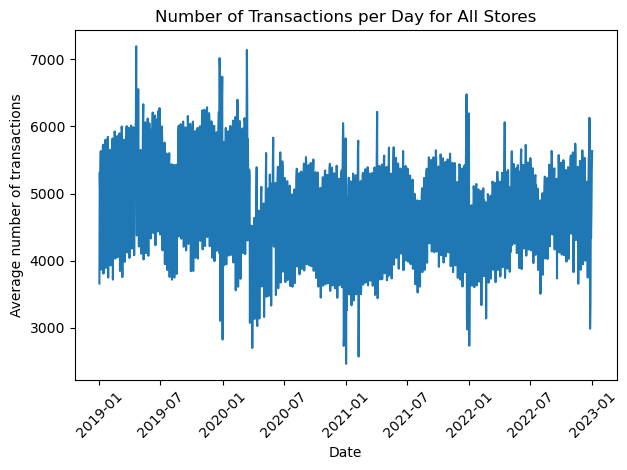

In [16]:
# I plot an aggregated time series of the number of transactions per day for all stores

#build aggregated time series
aggregated_df  = df_preprocessed.groupby(['sales_date']).agg({'n_transactions': 'mean'}).reset_index()
plt.plot(aggregated_df['sales_date'], aggregated_df['n_transactions'])
plt.title('Number of Transactions per Day for All Stores')
plt.xlabel('Date')
plt.ylabel('Average number of transactions')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('aggregated_transactions.png')
plt.show()

What I first notice is the effect of Covid pandemic on the daily transactions. So, I include a dummy variable to account for the Covid Pandemic days (It is already included in the preprocesed dataset). I consider only the most restrictive period in the Netherlands (untile July 2021). Nevertheless, I could also consider before and after Covid periods since I could argue there were significant changes in the sector overall (like the development of online supermarket business like Picnic) that most likely changed the consumer behavior in the Netherlands. However, I assume I don't have sufficient domain knowledge to make a decission like that and I restric myself to only considering Covid restrictions. 

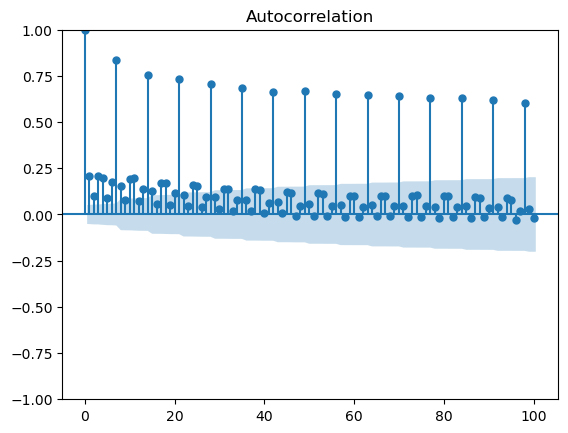

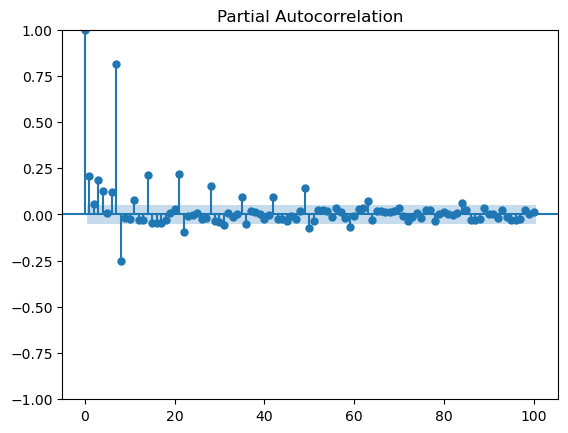

In [17]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

plot_acf(aggregated_df['n_transactions'], lags=100) # e.g., look at up to 50 lags
plt.show()
plot_pacf(aggregated_df['n_transactions'], lags=100)
plt.show()

The output of these two plots suggests that the aggregated data describes an AR (Auto regressive process) with lags spannig up to 7 weeks. More exactly, based on the partial autocorrelation graph I decide on considering 7 lags correspoinding to 7 days before the date and 7 weekly lags.

 I note here there will be NaN values in the data set that I will not exclude since for the global model I will use a gradient boosting model (LightGBM) which natively support NaN values. 

In [18]:
lags = [1, 2, 3, 4, 5, 6, 7,8, 14, 21, 28, 35, 42, 49]
df_train = utils.add_lags(train_set, lags)
df_train.head()

,sales_date,store_hashed,n_transactions,store_format,zipcode_region,region,holiday_saint_nicholas,holiday_first_christmas,holiday_liberation_day,holiday_good_friday,...,n_transactions_lag_5,n_transactions_lag_6,n_transactions_lag_7,n_transactions_lag_8,n_transactions_lag_14,n_transactions_lag_21,n_transactions_lag_28,n_transactions_lag_35,n_transactions_lag_42,n_transactions_lag_49
482865,2021-12-15,01eee509ee2f68dc6014898c309e86bf,4269,19,30,middle,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
114297,2021-12-16,01eee509ee2f68dc6014898c309e86bf,3865,19,30,middle,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
512490,2021-12-17,01eee509ee2f68dc6014898c309e86bf,3396,19,30,middle,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
114324,2021-12-18,01eee509ee2f68dc6014898c309e86bf,3644,19,30,middle,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
129107,2021-12-19,01eee509ee2f68dc6014898c309e86bf,3167,19,30,middle,0,0,0,0,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


In [19]:
categorical_features = ['store_hashed', 'store_format', 'zipcode_region', 'region', 'openning_hour', 'closing_hour', 'day_of_week', 'day_of_month',
       'day_of_year', 'week_of_year', 'month']

# Build the X_train and y_train used for training the model

X_train= df_train.drop(columns=['n_transactions', 'sales_date'])
X_train = X_train.drop(columns = ['datetime_store_open','datetime_store_closed', 'is_national_holiday', 'is_test'])
y_train = df_train['n_transactions']

# Convert categorical features to category type
learned_categories_from_training = {}

for col in categorical_features:
    if col in X_train.columns: 
        X_train[col] = X_train[col].astype('category')
        test_set[col] = test_set[col].astype('category')

        learned_categories_from_training[col] = X_train[col].cat.categories



In [20]:
# I use optuna to tune the hyperparameters of the LightGBM model. 
from global_model_util import objective_function
import optuna
import lightgbm as lgb
# --- Create and Run Optuna Study ---
#study = optuna.create_study(
#     direction='minimize', 
#     pruner=optuna.pruners.MedianPruner(n_warmup_steps=2)) 
#
# # Pass additional arguments (X_data, y_data, categorical_feature_names) to the objective function
#study.optimize(lambda trial: objective(trial, X_train, y_train, categorical_features), 
#                n_trials=20) # Adjust n_trials based on available time/resources
#
#print("\nHyperparameter tuning complete.")
#print("Best trial:")
#best_trial = study.best_trial
#print(f"  Value (Average MAE): {best_trial.value:.4f}")
#print("  Best Parameters: ")
#for key, value in best_trial.params.items():
#    print(f"    {key}: {value}")

#best_lgbm_params = best_trial.params

#####BEST PARAMETERS###############
best_params = {
        'objective': 'regression_l2',
        'metric': 'mse',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'random_state': 42,
        'n_jobs': -1,
        'n_estimators': 900, 
        'learning_rate': 0.020138867452472654,
        'num_leaves': 385,
        'max_depth': 15,
        'min_child_samples': 37,
        'subsample': 0.6877992009035293,
        'colsample_bytree': 0.6330416399527163,
        'reg_alpha': 8.897837733245082e-07,
        'reg_lambda': 3.160525896275111e-06,
    }


final_model = lgb.LGBMRegressor(**best_params,)
final_model.fit(X_train, y_train,
                categorical_feature=categorical_features)
print("Final model trained.")

Final model trained.


In [21]:
from global_model_util import get_buffer_df
from global_model_util import recursive_forecast

# I use a buffer of 70 days from the training set to help me build the lag variables for the test set
buffer = get_buffer_df(train_set, size = 70)

In [22]:
#get the recursive predictions for the test set
#RUNNING TIME WARNING: approximately 8 minutes running time
recursive_predictions_df = recursive_forecast(buffer, test_set, final_model, lags, categorical_features)

Overall RMSE-Recursive: 447.863422881742, Overall MAE-recursive: 268.6073725880533, Overal MAPE-recursive:6.8343133812678545, Overall sMAPE-recursive: 6.5394547058756824
Overall RMSE-Naive: 543.0484196797898, Overall MAE-Naive: 312.78273588704184, Overal MAPE-naive:7.409203065941811, Overall sMAPE-Naive: 7.166939591158075


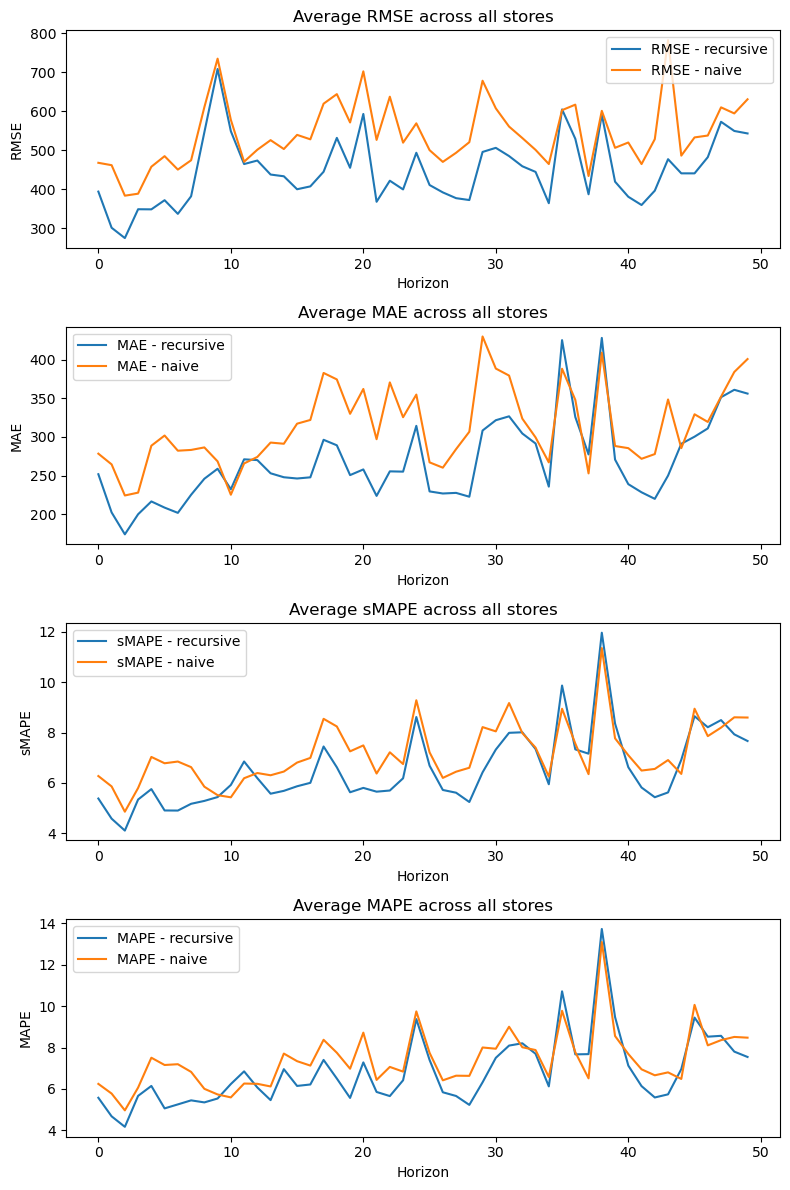

In [23]:
rmse_recursive, mae_recursive, mape_recursive, smape_recursive = utils.metrics_accross_horizon(recursive_predictions_df, naive = False)
print(f'Overall RMSE-Recursive: {rmse_recursive.mean()}, Overall MAE-recursive: {mae_recursive.mean()}, Overal MAPE-recursive:{mape_recursive.mean()}, Overall sMAPE-recursive: {smape_recursive.mean()}')
print(f'Overall RMSE-Naive: {rmse_naive.mean()}, Overall MAE-Naive: {mae_naive.mean()}, Overal MAPE-naive:{mape_values.mean()}, Overall sMAPE-Naive: {smape_naive.mean()}')

fig, ax = plt.subplots(4, 1, figsize=(8, 12))

for i, error_measure, error_value in zip(range(len(error_measures)),error_measures, [rmse_recursive, mae_recursive, smape_recursive, mape_recursive]):
    ax[i].plot(error_value, label=f'{error_measure} - recursive')
    ax[i].set_title(f'Average {error_measure} across all stores')
    ax[i].set_xlabel('Horizon')
    ax[i].set_ylabel(error_measure)
    ax[i].legend()
for i, error_measure, error_value in zip(range(len(error_measures)),error_measures, [rmse_naive, mae_naive, smape_naive, mape_values]):
    ax[i].plot(error_value, label=f'{error_measure} - naive')
    ax[i].legend()
plt.tight_layout()
plt.show()

All the graphs indicate that the global recursive model performs on average better than the naive model. More exactly we can see an approximatelly 30% better global average RMSE and similarly, an approximately 25% better Global Average MAE. We do see however that the performace of the recursive model decreases in time, which is as expected. The main limitation of this approach is the most likely propagation in time of error in th beginig of the prediction horizon. Nevertheless, the global model is a clear improvement in comparison to the naive model. 

Next step is to visualize the robustness of this model in time. Again I use the model for the same points in time as I did with the naive model and I measure the global average errors. 

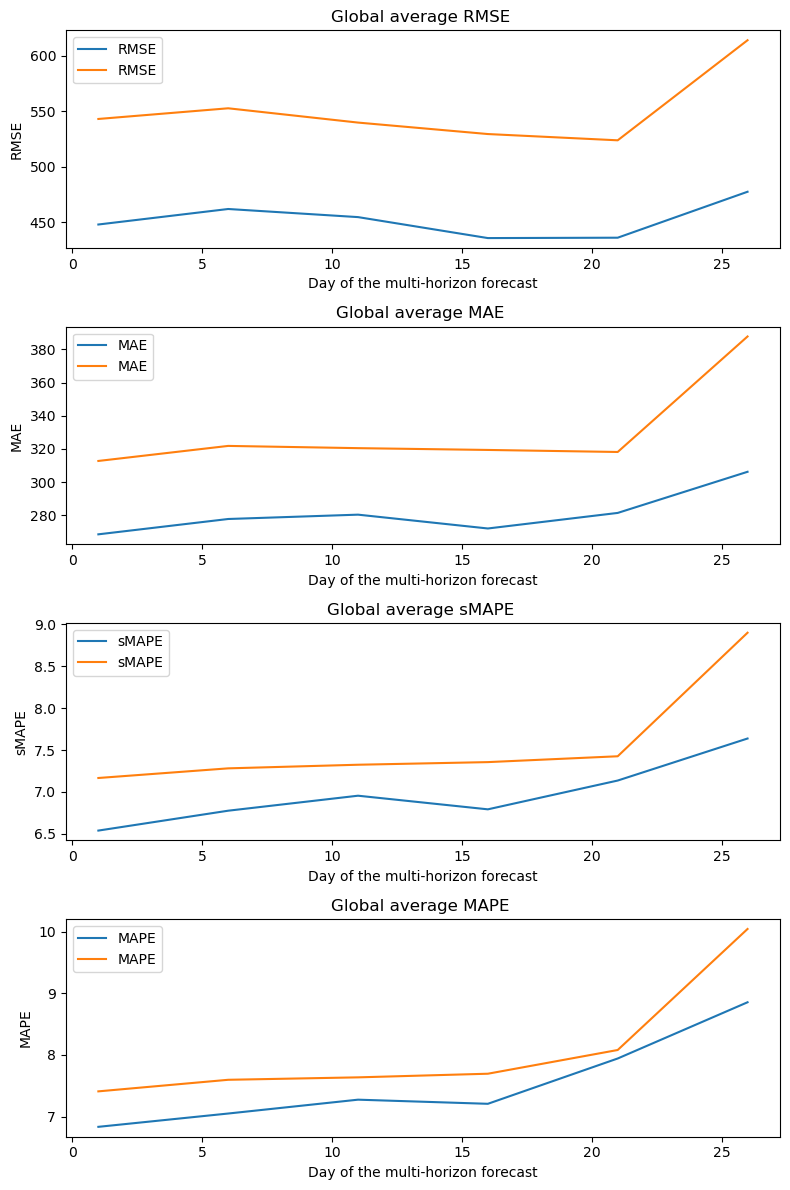

In [24]:
#GRMSE_recursive, GMAE_recursive, GSMAPE_recursive, GMAPE_recursive = rolling_window_forecast(test_set,buffer = buffer, model = final_model, lags = lags)
#export the resultls 
#rolling_window_recursive_results = pd.DataFrame({
#    'GRMSE': GRMSE_recursive,
#    'GMAE': GMAE_recursive,
#    'GsMAPE': GSMAPE_recursive,
#    'GMAPE': GMAPE_recursive
#})
#rolling_window_recursive_results.to_csv(f'{models_save_directory}/rolling_window_recursive_results.csv', index = False)

#load the results
rolling_window_recursive_results = pd.read_csv(f'{models_save_directory}/rolling_window_recursive_results.csv')
fig, ax = plt.subplots(4, 1, figsize=(8, 12))
days_of_forecast = np.arange(1, 31, 5)
for i, error_measure, error_value in zip(range(len(error_measures)), error_measures, rolling_window_recursive_results.columns):
    ax[i].plot(days_of_forecast, rolling_window_recursive_results[error_value].values, label=error_measure)
    ax[i].set_title(f'Global average {error_measure} ')
    ax[i].set_xlabel('Day of the multi-horizon forecast')
    ax[i].set_ylabel(error_measure)
    ax[i].legend()
for i, error_measure, error_value in zip(range(len(error_measures)), error_measures, rolling_window_naive_results.columns):
    ax[i].plot(days_of_forecast, rolling_window_naive_results[error_value], label=error_measure)
    ax[i].legend()
plt.tight_layout()
plt.show()



These graphs also confirm the Global recursive ML model delivers better predictive results than the naive model. 

Next I want to further investigate the **features importance** of the ML model to better understand what drives the predictive performance of the model 

In [25]:
import shap

explainer = shap.TreeExplainer(final_model)

In [26]:
X_sample_for_shap = X_train.sample(n=min(5000, len(X_train)), random_state=1)
shap_values = explainer.shap_values(X_sample_for_shap)


Generating SHAP Bar Plot...


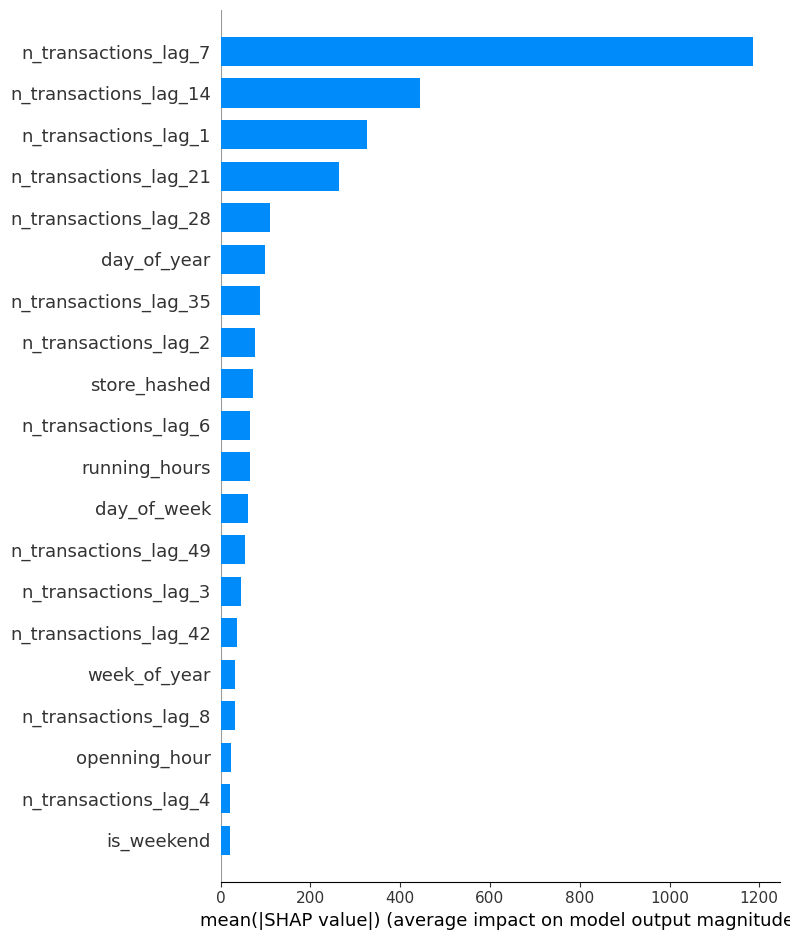

In [27]:
print("\nGenerating SHAP Bar Plot...")
shap.summary_plot(shap_values, X_sample_for_shap, plot_type="bar")
plt.show()

The output of SHAP confirms the output of the PACF graph that we have seen earlier. Indeed, the lagged variables are the most important predictors of our model. 

## Global ML model:  direct-recursive hybrid approach 

**The approach I consider for investigating the posibility of improving upon the Global recursive model is a combination between n direct models used in a recursive way**.

For example, I train 7 direct model. One model for 1 step ahead predictions, one model for 2 steps ahead predictions,...one models for 7 steps ahead predictions. After that, for step 8 prediction I use in a recursive way the one step ahead model, and so on until the end of the 50 days forecasting horizon. 

In [28]:
import joblib
#Running time warning: approximately 45 minutes
# I save the model in a directory called "my_direct_models"

#from global_model_util import train_direct_models
#train_direct_models(train_set,categorical_features=categorical_features, n_direct_models = 10)

models_load_directory = "my_direct_models" 
direct_models = {}

for h in range(2, 11):
    model_name = f"model_{h}"
    file_path = os.path.join(models_load_directory, f"{model_name}.joblib")

    try:
        direct_models[model_name] = joblib.load(file_path)
        print(f"Loaded: {file_path}")
    except FileNotFoundError:
        print(f"ERROR: Model file not found at {file_path}")
    except Exception as e:
        print(f"ERROR: Could not load model {model_name}. Reason: {e}")

direct_models['model_1'] = final_model

Loaded: my_direct_models/model_2.joblib
Loaded: my_direct_models/model_3.joblib
Loaded: my_direct_models/model_4.joblib
Loaded: my_direct_models/model_5.joblib
Loaded: my_direct_models/model_6.joblib
Loaded: my_direct_models/model_7.joblib
Loaded: my_direct_models/model_8.joblib
Loaded: my_direct_models/model_9.joblib
Loaded: my_direct_models/model_10.joblib


In [29]:
from global_model_util import hybrid_forecast
#RUNNING TIME WARNING: approximately 10 minutes running time
hybrid_predictions_df = hybrid_forecast(buffer_df = buffer, test_set=test_set, models=direct_models, categorical_features=categorical_features, lags=lags)

In [30]:
rmse_hybrid, mae_hybrid, mape_hybrid, smape_hybrid = utils.metrics_accross_horizon(hybrid_predictions_df, naive = False)

Overall RMSE-Hybrid: 540.8328547050052, Overall MAE-Hybrid: 303.8478004679581, Overal MAPE-Hybrid:7.516519693679429, Overall sMAPE-Hybrid: 7.160060621390475
Overall RMSE-Naive: 543.0484196797898, Overall MAE-Naive: 312.78273588704184, Overal MAPE-Naive:7.409203065941811, Overall sMAPE-Naive: 7.166939591158075
Overall RMSE-Recursive: 447.863422881742, Overall MAE-Recursive: 268.6073725880533, Overal MAPE-Recursive:6.8343133812678545, Overall sMAPE-LGBRecursiveM: 6.5394547058756824


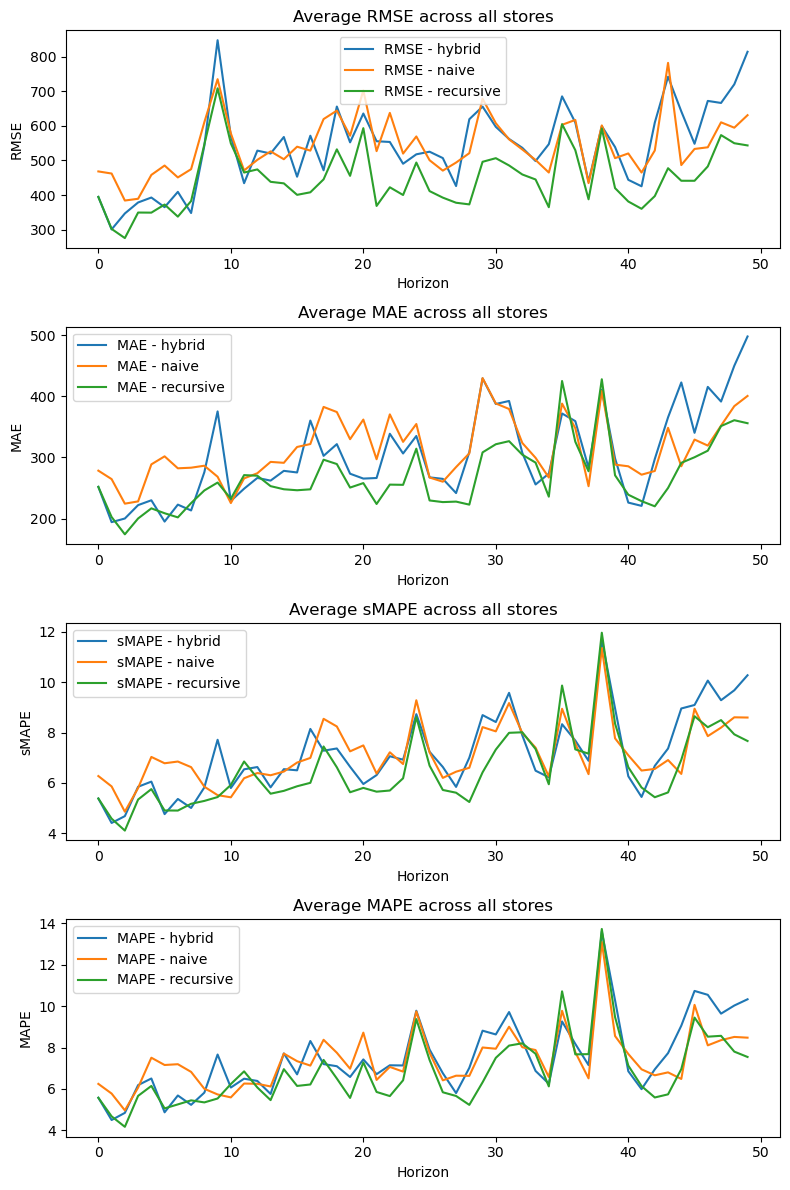

In [31]:
print(f'Overall RMSE-Hybrid: {rmse_hybrid.mean()}, Overall MAE-Hybrid: {mae_hybrid.mean()}, Overal MAPE-Hybrid:{mape_hybrid.mean()}, Overall sMAPE-Hybrid: {smape_hybrid.mean()}')
print(f'Overall RMSE-Naive: {rmse_naive.mean()}, Overall MAE-Naive: {mae_naive.mean()}, Overal MAPE-Naive:{mape_values.mean()}, Overall sMAPE-Naive: {smape_naive.mean()}')
print(f'Overall RMSE-Recursive: {rmse_recursive.mean()}, Overall MAE-Recursive: {mae_recursive.mean()}, Overal MAPE-Recursive:{mape_recursive.mean()}, Overall sMAPE-LGBRecursiveM: {smape_recursive.mean()}')


fig, ax = plt.subplots(4, 1, figsize=(8, 12))
for i, error_measure, error_value in zip(range(len(error_measures)),error_measures, [rmse_hybrid, mae_hybrid, smape_hybrid, mape_hybrid]):
    ax[i].plot(error_value, label=f'{error_measure} - hybrid')
    ax[i].set_title(f'Average {error_measure} across all stores')
    ax[i].set_xlabel('Horizon')
    ax[i].set_ylabel(error_measure)
    ax[i].legend()
for i, error_measure, error_value in zip(range(len(error_measures)),error_measures, [rmse_naive, mae_naive, smape_naive, mape_values]):
    ax[i].plot(error_value, label=f'{error_measure} - naive')
    ax[i].legend()
for i, error_measure, error_value in zip(range(len(error_measures)),error_measures, [rmse_recursive, mae_recursive, smape_recursive, mape_recursive]):
    ax[i].plot(error_value, label=f'{error_measure} - recursive')
    ax[i].legend()
plt.tight_layout()
plt.show()

At this point I see no evidences that this hybrid approach improves upon the results of the global recursive model.

## Future developments 

 - Develop the feature engineering aspect of the model development. For example, it's possible that aggregated feature like total number of transactions over different time windows can improve the performance of the model. 
 - Explore different loss functions used in training the models. I restricted my search to MSE and MAE, but there are multiple other possibilities. 
 - Look into making the code more efficient in terms of time complexity. Some aspects of the algorithms developed could further be improved
 - Finally, I would research other options for the direct approach. For example DNN that can support a vector output. It could allow for developing a global direct model that could output the entire predictive horizon at once. 

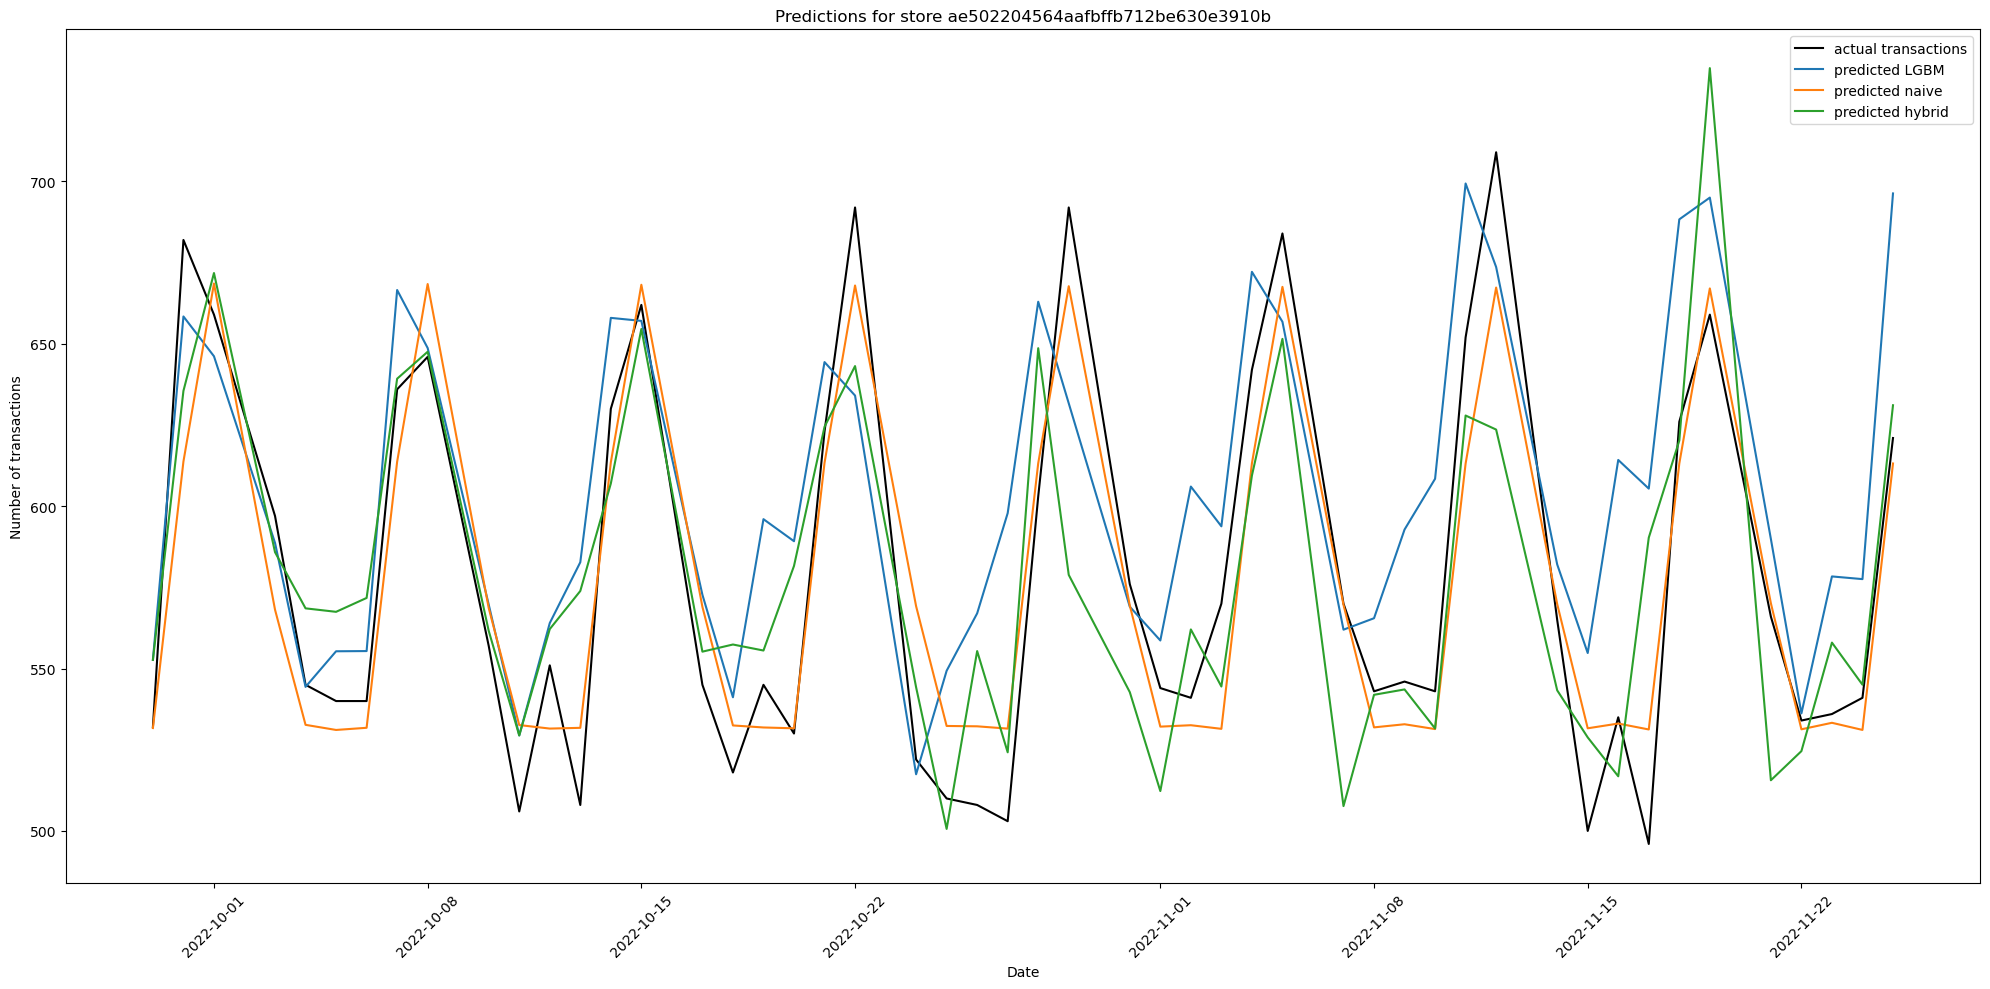

In [36]:
# This final cell is used to plot the predictions of the three models for a random store
store = random.sample(list(test_set['store_hashed'].unique()), 1)[0]
store_test_naive = test_df_naive[test_df_naive['store_hashed'] == store].copy()
store_test_recursive = recursive_predictions_df[recursive_predictions_df['store_hashed'] == store].copy()
store_test_hybrid = hybrid_predictions_df[hybrid_predictions_df['store_hashed'] == store].copy()

#plot y_test and y_hat
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(store_test_recursive['sales_date'], store_test_recursive['n_transactions'], label='actual transactions', color = 'black')
ax.plot(store_test_recursive['sales_date'], store_test_recursive['predicted_n_transactions'], label='predicted LGBM')
ax.plot(store_test_naive['sales_date'], store_test_naive['n_transactions'], label='predicted naive')
ax.plot(store_test_hybrid['sales_date'], store_test_hybrid['predicted_n_transactions'], label='predicted hybrid')
ax.legend()
ax.set_title(f'Predictions for store {store}')
ax.set_xlabel('Date')
ax.set_ylabel('Number of transactions')
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()